## Importing libraries

In [177]:
import pandas as pd # to store data efficiently
import numpy as np # to handle numerical operations
import random # to generate random numbers
import os # to handle operations regarding file system
import wget # to download locally images
from ultralytics import YOLO # to import YOLO model
from tqdm import tqdm # to visualize loop progressions
import matplotlib.pyplot as plt # to create visualizations
import cv2 # to handle images
import re


## Getting images list with people from COCO dataset

In [178]:
anns_df = pd.read_csv('./data/coco_diff/single_anns/person_anns.csv')

In [179]:
img_url_list = list(anns_df['img_url'].unique())
print(len(img_url_list))

58883


## Random sampling from that list and download locally images

In [180]:
random.seed(24) # to use same collection of images
img_sample = random.sample(img_url_list, 2000)

### Downloads images inside list

In [181]:
# Changes cwd (to download image via wget in) and then changes it back
old_cwd = os.getcwd()
new_cwd = old_cwd+'/imgs'
os.chdir(new_cwd)
for url in tqdm(img_sample):
    try:
        file_name = url.split('/')[-1]
        file_path = os.path.join(new_cwd, file_name)
        
        if not os.path.exists(file_path):
            wget.download(url)
    except Exception as e:
        print(f"\nError in download of {url}: {e}")
os.chdir(old_cwd)

100%|██████████| 2000/2000 [00:00<00:00, 57356.04it/s]


In [182]:
model = YOLO("./models/YOLO/yolo11n.pt")

In [183]:
def predict_image_cropped(source: str, crop_part: str = None, crop_factor: int = None):
    if crop_part and crop_factor:
        for filename in tqdm(os.listdir(source)):
            if filename.endswith('.jpg'):  # Controlla che sia un file JPG
                image_path = os.path.join(source, filename)
                
                # Carica l'immagine
                image = cv2.imread(image_path)
                
                # Controlla che l'immagine sia stata caricata correttamente
                if image is None:
                    print(f"Error in image loading: {filename}")
                    continue
                
                # Ottieni dimensioni dell'immagine
                height, width, _ = image.shape
                
                # Calcola il ritaglio in base alla direzione e percentuale
                if crop_part == "top":
                    cropped_image = image[:height * crop_factor // 100, :, :]
                elif crop_part == "side":
                    cropped_image = image[:, :width * crop_factor // 100, :]
                else:
                    print(f"Invalid crop: {crop_part}. Use 'top' or 'side'.")
                    continue
                
                # Predizione immediata per l'immagine ritagliata
                result = model.predict(source=[cropped_image], verbose=False)
                yield [result, image_path]  # Ritorna il risultato come stream
                
    else:
        print('Error in parameters')        

In [184]:
df_names = ['All', 'Top25', 'Top50', 'Top75', 'Side25', 'Side50', 'Side75']

### Get confidence score for both all and cropped images

In [185]:
def get_img_info(res, img_id: str, detection_list: list) -> None:
    # Get mask for class 0
        class_mask = res.boxes.cls == 0
        
        # Get all relevant data in one go
        confidences = res.boxes.conf[class_mask]
        dimensions = res.boxes.xywhn[class_mask]
        
        # Print results using zip to iterate both arrays simultaneously
        for index, (conf, dim) in enumerate(zip(confidences, dimensions)):
            detection_dict = {}  # Crea un nuovo dizionario per ogni rilevamento
            detection_dict['Img_ID'] = img_id
            detection_dict['Confidence'] = conf.item()
            detection_dict['Dimensions'] = dim.tolist()
            detection_dict['ID'] = f'{img_id}{index}'
            detection_list.append(detection_dict)
        
        # Add specific case if no person is detected
        if len(confidences) == 0:
            detection_dict = {  
                'Img_ID': img_id,
                'Confidence': 0,
                'Dimensions': [],
                'ID': img_id
            }
            detection_list.append(detection_dict)

In [186]:
def confidence_score(result_img, cropped: bool = False) -> list:
    detection_list = []
    for res in result_img:
        if cropped:
            img_id = res[1].split('\\')[-1].strip('.jpg').lstrip('0')
            res = res[0][0]
        else:
            img_id = res.path.split('\\')[-1].strip('.jpg').lstrip('0')
        get_img_info(res, img_id, detection_list)
    return detection_list


In [187]:
img_source = './imgs'

predict_raw = model.predict(source=img_source, verbose=True)

predicts_obj_list = []
predicts_obj_list.append(confidence_score(predict_raw))
for name in df_names[1:]:
    if bool(re.search(r'\d', name)):
        direction = (name[:-2]).lower() # True se ci sono numeri, False altrimenti
        crop_factor = int(name[-2:])
        predict_raw = list(predict_image_cropped(img_source, direction, crop_factor))
        predicts_obj_list.append(confidence_score(predict_raw, cropped=True))




WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2001 c:\Users\fedep\OneDrive\Desktop\Universita'\Year 2\PER\FemaleObjectificationInMovies\imgs\000000000326.jpg: 448x640 1 person, 1 tennis racket, 1 wine glass, 216.1ms
image 2/2001 c:\Users\fedep\OneDrive\Desktop\Universita'\Year 2\PER\FemaleObjectificationInMovies\imgs\000000001149.jpg: 448x640 13 persons, 6 ties, 157.9ms
image 3/2001 c:\Users\fedep\OneDrive\Desktop\Universita'\Year 2\PER\FemaleObjectificationInMovies\imgs\000000001200.jpg: 64

100%|██████████| 2001/2001 [06:04<00:00,  5.49it/s]


In [189]:
pred_df_list = []
for obj, name in zip(predicts_obj_list, df_names):
    df = pd.DataFrame(obj).set_index('ID')
    df['x_center'] = df['Dimensions'].apply(lambda x: x[0] if x else np.nan)
    df['y_center'] = df['Dimensions'].apply(lambda x: x[1] if x else np.nan)
    df['width'] = df['Dimensions'].apply(lambda x: x[2] if x else np.nan)
    df['height'] = df['Dimensions'].apply(lambda x: x[3] if x else np.nan)
    df = df.drop(['Dimensions'], axis=1)
    pred_df_list.append(df)
    df.to_csv(f'./data/yolo_prediction/{name}.csv', index=True)

In [190]:
grouped_df = pred_df_list[0].groupby('Img_ID')[['Confidence']].mean()

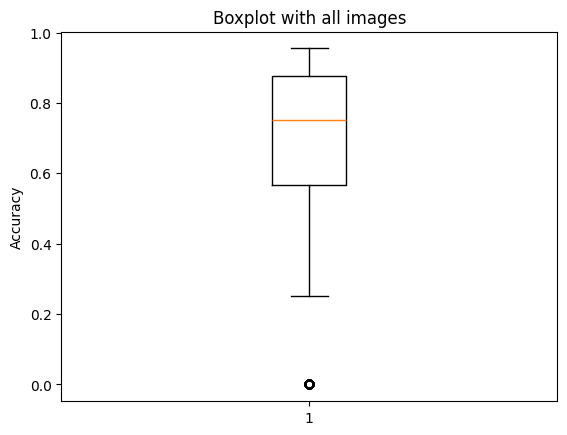

In [191]:
plt.boxplot(grouped_df)

plt.title("Boxplot with all images")
plt.ylabel("Accuracy")
plt.show()

In [192]:
df[(df['Confidence']==0)]

,Img_ID,Confidence,x_center,y_center,width,height
ID,,,,,,
1319,1319,0.0,NaN,NaN,NaN,NaN
2555,2555,0.0,NaN,NaN,NaN,NaN
2764,2764,0.0,NaN,NaN,NaN,NaN
6662,6662,0.0,NaN,NaN,NaN,NaN
6789,6789,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
550834,550834,0.0,NaN,NaN,NaN,NaN
561390,561390,0.0,NaN,NaN,NaN,NaN
563947,563947,0.0,NaN,NaN,NaN,NaN
